In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import time

import cv2
from PIL import Image
from scipy import ndimage as ndi

from skimage import exposure, io, img_as_float, data, measure, segmentation, color, filters, future
from skimage.color import rgb2gray
from skimage.feature import peak_local_max, canny
from skimage.filters import sobel, rank, gaussian
from skimage.measure import regionprops
from skimage.morphology import disk, remove_small_objects, dilation, square
from skimage.segmentation import watershed, felzenszwalb, slic, morphological_geodesic_active_contour, inverse_gaussian_gradient
from skimage.transform import resize
from skimage.util import img_as_float

from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering, OPTICS, SpectralClustering, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelPropagation

In [6]:
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [8]:
data_train_path = Path('data/images_hTE3Lse/images')
data_test_path = Path('data/images_ZKlXDOZ/images')

data_train = load_dataset(data_train_path)
print("Loaded data_train:", data_train.shape)
data_test = load_dataset(data_test_path)
print("Loaded data_test:", data_test.shape)

Loaded data_train: (2000, 512, 512)
Loaded data_test: (500, 512, 512)


In [9]:
# Load half-supervised labels
labels = pd.read_csv(
    'data/label_rphifOX.csv',
    index_col=0,
)
print("Loaded labels:", labels.shape)
labels = labels.T
labels.head()

Loaded labels: (262144, 2000)


,Pixel 0,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,...,Pixel 262134,Pixel 262135,Pixel 262136,Pixel 262137,Pixel 262138,Pixel 262139,Pixel 262140,Pixel 262141,Pixel 262142,Pixel 262143
0.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Display the first 5 label maps
sum_per_line = labels.sum(axis=1)
index_supervised = sum_per_line[sum_per_line > 0].index
print("Count with labels:", len(index_supervised))
print("Indexes with labels:", index_supervised.tolist())

Count with labels: 400
Indexes with labels: ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.p

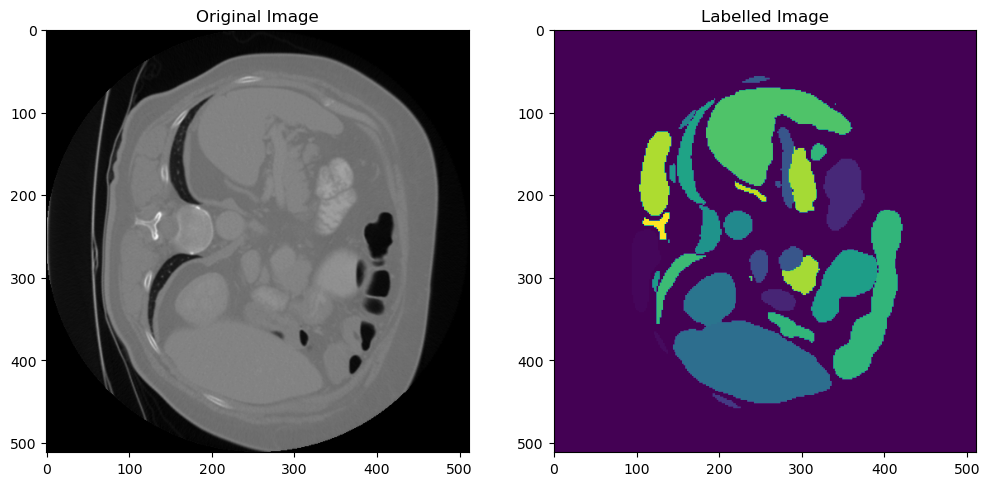

In [11]:
def label_to_image(label):
    return label.to_numpy().reshape(512, 512)

test = labels.iloc[2]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axs[0].imshow(data_train[2], cmap='gray')
axs[0].set_title('Original Image')

# Plot the label image
axs[1].imshow(label_to_image(test))
axs[1].set_title('Labelled Image')

plt.show()

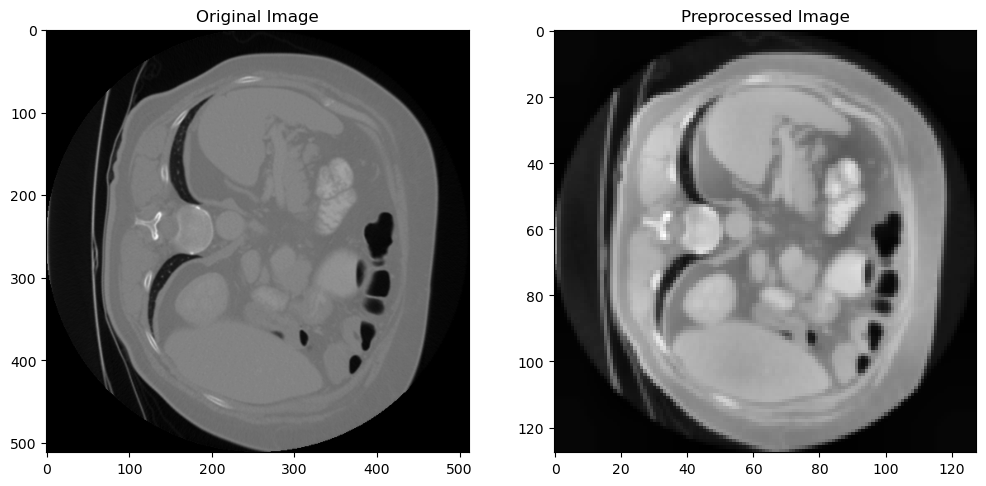

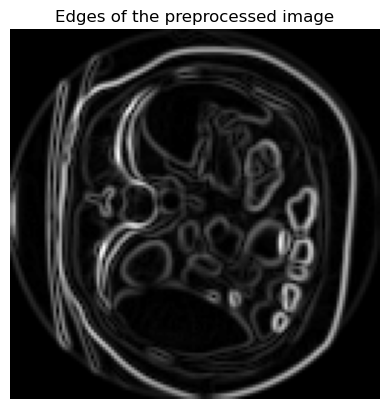

In [12]:
def preprocess_image(image):
    # Convert to float for further processing
    image_float = img_as_float(image)
    
    # Apply Gaussian filter for smoothing
    smoothed = gaussian(image_float, sigma=1)
    
    # Enhance contrast using adaptive histogram equalization (CLAHE expects uint8)
    smoothed_uint8 = (smoothed * 255).astype("uint8")
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(smoothed_uint8)
    
    # Normalize the intensity values (back to [0, 1] for further processing)
    normalized = equalized / 255.0
    
    # Apply median filter to reduce noise
    denoised = ndi.median_filter(normalized, size=5)
    
    # Resize the image to a fixed size
    resized = resize(denoised, (128, 128), anti_aliasing=True)
    
    return resized

def get_edges(image):
    edges = sobel(image)
    edges_int = (edges * 255).astype(np.uint8)
    return edges_int

# Test preprocessing on one image
image = data_train[2]
preprocessed_image = preprocess_image(image)

# Visualize original and preprocessed image
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image, cmap='gray')
axs[1].set_title('Preprocessed Image')
plt.show()

edges = get_edges(preprocessed_image)

plt.imshow(edges, cmap='gray')
plt.title('Edges of the preprocessed image')
plt.axis('off')
plt.show()

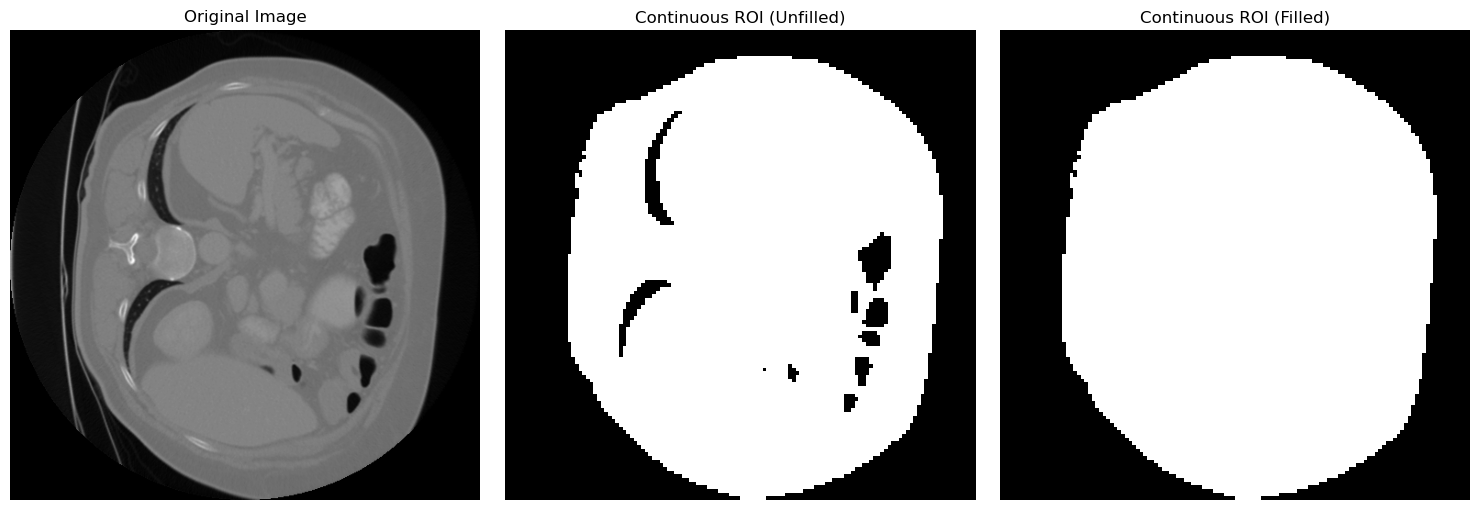

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, measure, morphology
from scipy.ndimage import binary_fill_holes

# Assuming preprocessed_image is already obtained
image = data_train[2]
preprocessed_image = preprocess_image(image)

# Apply Otsu's thresholding
threshold = filters.threshold_otsu(preprocessed_image)
binary_mask = preprocessed_image > threshold

# Select the largest connected component to ensure continuity
labeled_mask = measure.label(binary_mask)
regions = measure.regionprops(labeled_mask)
largest_region = max(regions, key=lambda r: r.area)  # Find the largest region
continuous_mask = labeled_mask == largest_region.label

filled_mask = binary_fill_holes(continuous_mask)

# Visualize the result
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(continuous_mask, cmap='gray')
axes[1].set_title('Continuous ROI (Unfilled)')
axes[1].axis('off')

axes[2].imshow(filled_mask, cmap='gray')
axes[2].set_title('Continuous ROI (Filled)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


c:\Users\sacha\miniconda3\envs\ECN_APP_STAT\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\sacha\miniconda3\envs\ECN_APP_STAT\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\sacha\miniconda3\envs\ECN_APP_STAT\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sacha\miniconda3\envs\ECN_APP_STAT\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\sacha\miniconda3\envs\ECN_APP

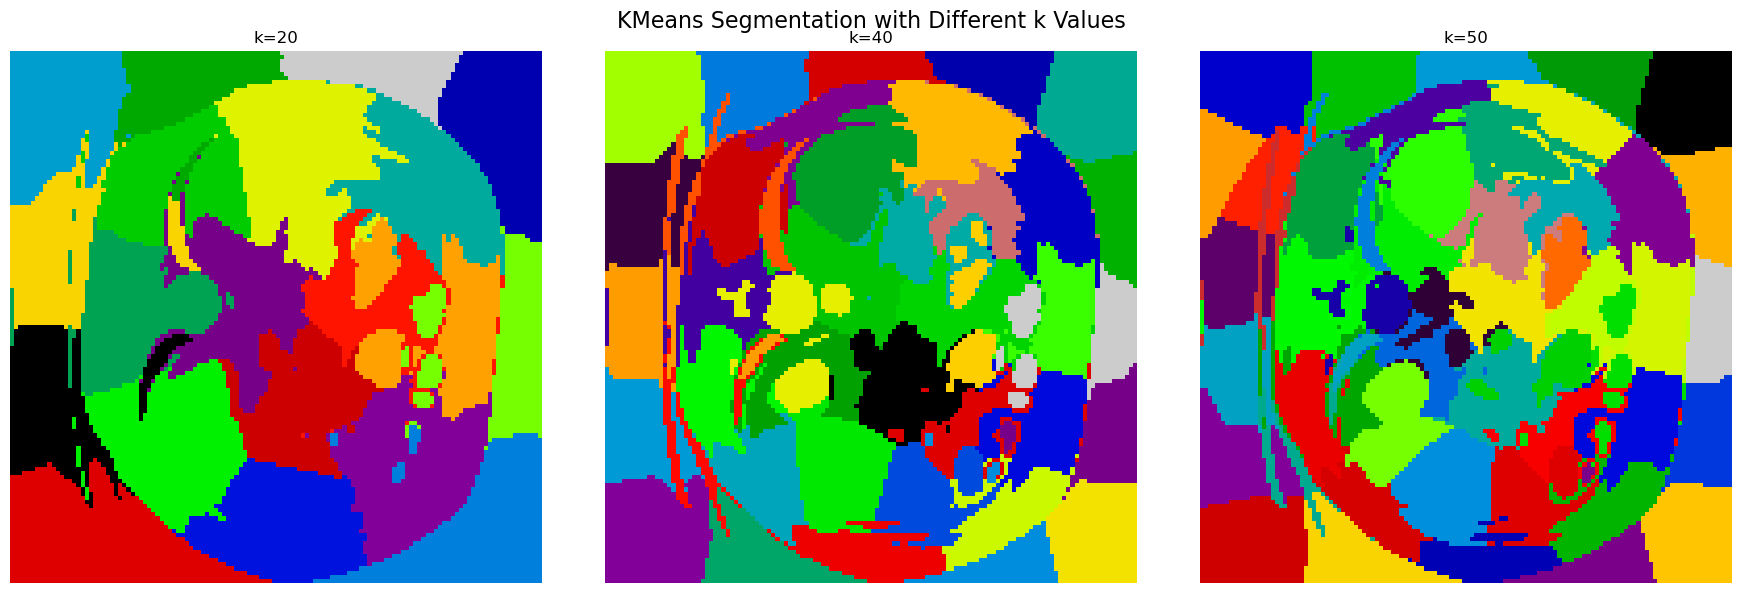

In [13]:
# Define the range of k values
k_values = [20, 40, 50]

# Preprocess the image
image = data_train[2]
preprocessed_image = preprocess_image(image)

# Get image dimensions
height, width = preprocessed_image.shape

# Flatten intensity values
pixel_values = preprocessed_image.flatten()

# Generate spatial coordinates
X, Y = np.meshgrid(np.arange(width), np.arange(height))
X = X.flatten()
Y = Y.flatten()

# Combine features: intensity + spatial coordinates
features = np.stack((pixel_values, X, Y), axis=-1)

# Normalize all features to have mean 0 and std 1
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Plot the results for each k value
fig, axs = plt.subplots(1, len(k_values), figsize=(18, 6))
fig.suptitle('KMeans Segmentation with Different k Values', fontsize=16)

for i, k in enumerate(k_values):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, n_init=25, tol = 0.00001, algorithm= 'elkan')
    kmeans.fit(features_scaled)
    cluster_labels = kmeans.labels_

    # Reshape labels back to the image shape
    new_segmented_image_ms = cluster_labels.reshape(height, width)

    # Visualize the segmented image
    axs[i].imshow(new_segmented_image_ms, cmap='nipy_spectral')
    axs[i].set_title(f'k={k}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [14]:
#plot unique values in kmeans
unique, counts = np.unique(new_segmented_image_ms, return_counts=True)

print(unique)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
[515 215 366 245 479 389 266 179 292 476 404 328 234 147 501 225 390 293
 425 151 383 427 324 235 355 403 203 182 301 449 445 407 290 376 366 368
 361 463 307 260 166 251 258 327 394 283 504 139 347 290]


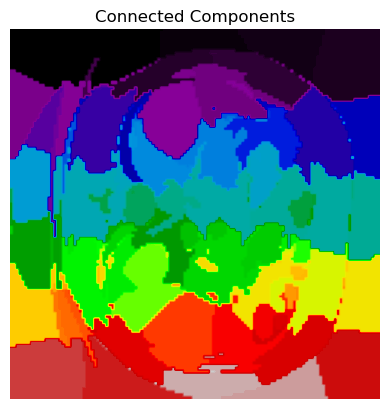

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [15]:
segmented_image = measure.label(new_segmented_image_ms, connectivity = 1, background=-1)

plt.imshow(segmented_image, cmap='nipy_spectral')
plt.title('Connected Components')
plt.axis('off')
plt.show()

#plot unique values in kmeans
unique, counts = np.unique(segmented_image, return_counts=True)

print(unique)
print(counts)

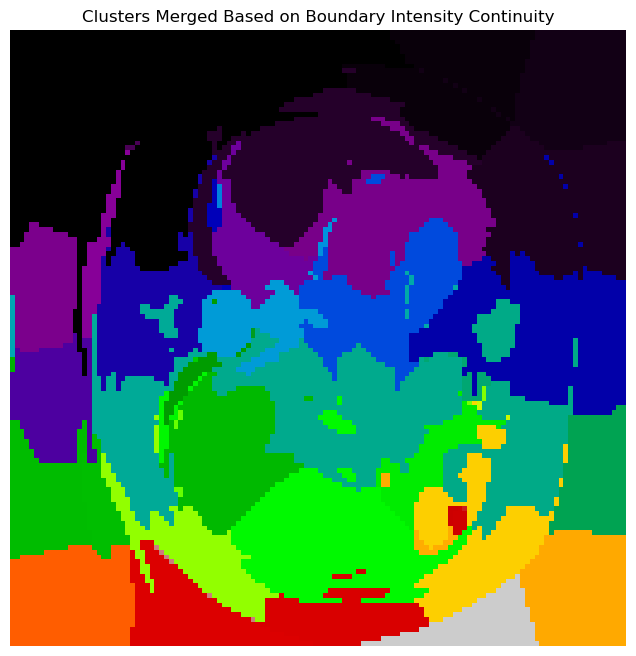

In [20]:
import numpy as np
import networkx as nx
from skimage.measure import regionprops
from skimage.morphology import dilation, square
import matplotlib.pyplot as plt

# Function to build RAG using `networkx`
def build_rag_mean_color(image, labels):
    rag = nx.Graph()
    regions = regionprops(labels, intensity_image=image)
    
    # Add nodes with mean intensity as attributes
    for region in regions:
        rag.add_node(region.label, mean_intensity=region.mean_intensity)
    
    # Add edges based on adjacency
    for src in rag.nodes:
        src_mask = (labels == src)
        for dst in rag.nodes:
            if src >= dst:
                continue
            dst_mask = (labels == dst)
            # Check adjacency using dilation
            if np.any(dilation(src_mask, square(3)) & dst_mask):
                rag.add_edge(src, dst)
    
    return rag

# Function to compute boundary intensity difference
def boundary_intensity_difference(rag, src, dst):
    src_mask = (segmented_image == src)
    dst_mask = (segmented_image == dst)
    
    # Boundary masks
    src_boundary = src_mask & dilation(dst_mask, square(5))
    dst_boundary = dst_mask & dilation(src_mask, square(5))
    
    # Boundary intensities
    src_boundary_intensity = preprocessed_image[src_boundary]
    dst_boundary_intensity = preprocessed_image[dst_boundary]
    
    # Compute mean intensity difference
    if src_boundary_intensity.size > 0 and dst_boundary_intensity.size > 0:
        intensity_diff = np.abs(src_boundary_intensity.mean() - dst_boundary_intensity.mean())
    else:
        intensity_diff = np.inf  # No boundary pixels
    
    return intensity_diff

# Build RAG
rag = build_rag_mean_color(preprocessed_image, segmented_image)

# Compute weights for all edges
for src, dst in rag.edges:
    rag[src][dst]['weight'] = boundary_intensity_difference(rag, src, dst)

# Threshold for merging regions
threshold = 10

# Merge regions based on threshold
for src, dst, data in list(rag.edges(data=True)):
    if data['weight'] < threshold:
        nx.contracted_nodes(rag, src, dst, self_loops=False)

# Map nodes to new regions
new_labels = np.copy(segmented_image)
for node in rag.nodes:
    new_region = min(rag[node])  # Assign the minimum node as the label
    new_labels[segmented_image == node] = new_region

# Visualize the new segmented image
plt.figure(figsize=(8, 8))
plt.imshow(new_labels, cmap='nipy_spectral')
plt.title('Clusters Merged Based on Boundary Intensity Continuity')
plt.axis('off')
plt.show()


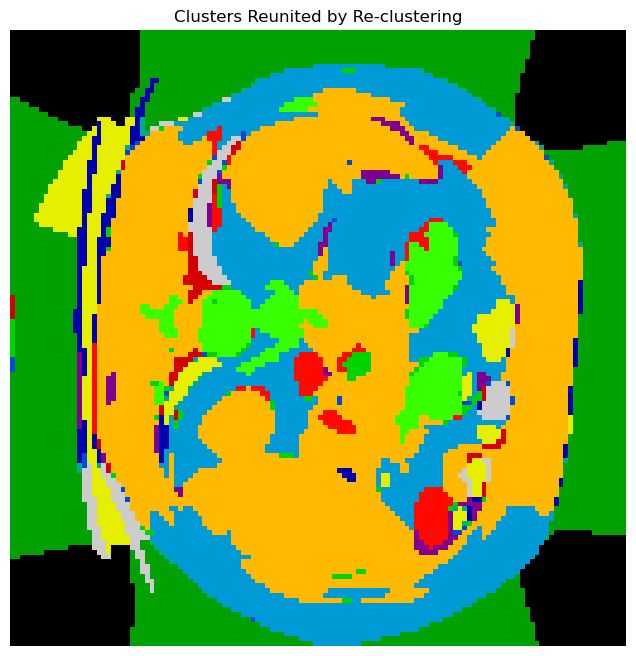

In [21]:
# Get unique labels
unique_labels = np.unique(segmented_image)

# Extract features for each cluster
cluster_features = []
for label in unique_labels:
    mask = segmented_image == label
    pixels = preprocessed_image[mask]
    mean_intensity = pixels.mean()
    std_intensity = pixels.std()
    size = pixels.size
    cluster_features.append([mean_intensity, std_intensity, size])

cluster_features = np.array(cluster_features)

# Scale features
scaler = StandardScaler()
cluster_features_scaled = scaler.fit_transform(cluster_features)

# Decide on the number of clusters (adjust as needed)
num_clusters = 14  # Adjust based on desired granularity

# Cluster the clusters
kmeans_clusters = KMeans(n_clusters=num_clusters, n_init=50, tol = 0.00001, algorithm= 'elkan')
kmeans_clusters.fit(cluster_features_scaled)
cluster_labels = kmeans_clusters.labels_

# Create a mapping from original cluster labels to new labels
label_mapping = dict(zip(unique_labels, cluster_labels))

# Reassign labels in the segmented image
seg_img_km_v2 = np.copy(segmented_image)
for original_label, new_label in label_mapping.items():
    seg_img_km_v2[segmented_image == original_label] = new_label

# Visualize the new segmented image
plt.figure(figsize=(8, 8))
plt.imshow(seg_img_km_v2, cmap='nipy_spectral')
plt.title('Clusters Reunited by Re-clustering')
plt.axis('off')
plt.show()

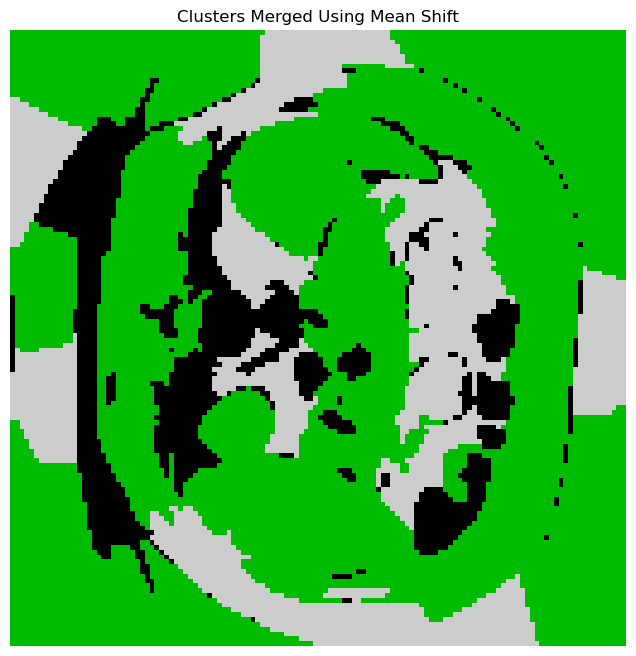

In [22]:
# Get unique labels
unique_labels = np.unique(segmented_image)

# Extract features for each cluster
cluster_features = []
for label in unique_labels:
    mask = segmented_image == label
    pixels = preprocessed_image[mask]
    mean_intensity = pixels.mean()
    std_intensity = pixels.std()
    size = pixels.size
    cluster_features.append([mean_intensity, std_intensity, size])

cluster_features = np.array(cluster_features)
    
# Estimate bandwidth for Mean Shift
bandwidth = estimate_bandwidth(cluster_features, quantile=0.1, n_samples=500)

# Perform Mean Shift clustering
mean_shift = MeanShift(bandwidth=bandwidth, min_bin_freq = 5, bin_seeding=True, cluster_all = True)
mean_shift.fit(cluster_features)
cluster_labels = mean_shift.labels_

# Create a mapping from original cluster labels to new labels
label_mapping = dict(zip(unique_labels, cluster_labels))

# Reassign labels in the segmented image
new_segmented_image_ms = np.copy(segmented_image)
for original_label, new_label in label_mapping.items():
    new_segmented_image_ms[segmented_image == original_label] = new_label

# Visualize the new segmented image
plt.figure(figsize=(8, 8))
plt.imshow(new_segmented_image_ms, cmap='nipy_spectral')
plt.title('Clusters Merged Using Mean Shift')
plt.axis('off')
plt.show()

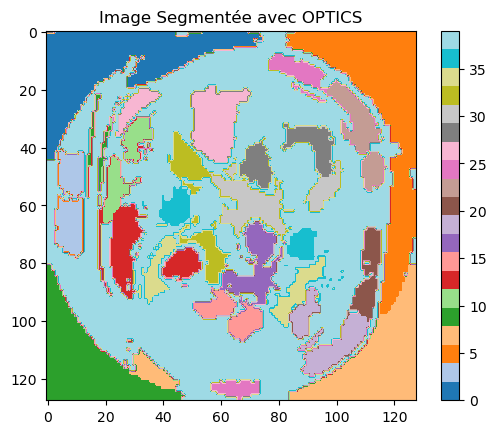

In [23]:
# Preprocess the image
image = data_train[2]  # Replace with your image
preprocessed_image = preprocess_image(image)

# Nouvelles dimensions
height, width = preprocessed_image.shape

# Coordonnées spatiales pour la nouvelle taille
X, Y = np.meshgrid(np.arange(width), np.arange(height))
X = X.flatten()
Y = Y.flatten()

# Mettre à jour les intensités et combiner les caractéristiques
pixel_values = preprocessed_image.flatten()
features = np.stack((pixel_values, X, Y), axis=-1)

# Normalize all features to have mean 0 and std 1
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Étape 3 : Appliquer OPTICS
# OPTICS avec métrique Euclidienne
clustering = OPTICS(min_samples=50, xi=0.001, min_cluster_size=0.005)
clustering.fit(features_scaled)

# Récupérer les labels des clusters
labels = clustering.labels_

# Étape 4 : Reconstruire l'image segmentée
# Créer une image où chaque pixel a la couleur de son cluster
segmented_image_optic = labels.reshape(height, width)

# Remplacer -1 (bruit) par une couleur différente (par exemple, -1 → max label + 1)
unique_labels = np.unique(labels)
max_label = max(unique_labels)
segmented_image_optic[segmented_image_optic == -1] = max_label + 1

# Afficher le résultat
plt.imshow(segmented_image_optic, cmap="tab20")
plt.title("Image Segmentée avec OPTICS")
plt.colorbar()
plt.show()

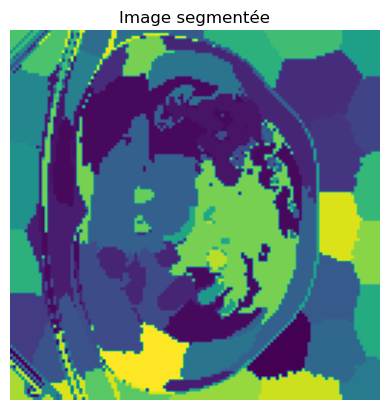

In [24]:
image = data_train[0]
preprocessed_image = preprocess_image(image)

# Get image dimensions
height, width = preprocessed_image.shape

# Flatten intensity values
pixel_values = preprocessed_image.flatten()

# Generate spatial coordinates
X, Y = np.meshgrid(np.arange(width), np.arange(height))
X = X.flatten()
Y = Y.flatten()

# Combine features: intensity + spatial coordinates
features = np.stack((pixel_values, X / width, Y / height), axis=-1)  # Normalize coordinates

# Normalize all features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Number of clusters
n_clusters = 40

# Spectral clustering with reduced neighbors
n_neighbors = 10  # Reduce for faster computation
spectral = SpectralClustering(
    n_clusters=n_clusters,
    affinity='sigmoid',
    n_neighbors=n_neighbors,
    random_state=42
)
labels = spectral.fit_predict(features_scaled)

# Reshape labels into the original image shape
segmented_image_spect = labels.reshape(height, width)

# Plot the segmented image
plt.imshow(segmented_image_spect, cmap='viridis')
plt.title("Image segmentée")
plt.axis('off')
plt.show()